# YCSB benchmarking evaluating MongoDB and MySQL

YCSB has been used as a tool for quantitiative comparison between two databases-MongoDB and MySQL. The YCSB benchmarking code can be found in copies of the terminal provided. The below code evaluates the two databases against one another. The trends in these results have been used to determine the best database in the context of the dataset used within this assessment. 

Broad patterns between the two databases in addition to a more specific comparison based on the parameters of the dataset have been included in this notebook- if aspects of my dataset change during the course of my analysis then I will use the more broad patterns to decide if the other database may be more suited to the new characteristics of my dataset. 

# Context of my dataset

The dataset used for this assessment is composed of a number of tweets collected over the course of a number of years regarding Brexit. The dataset contains information regarding the tweets including the individual who posted, their twitter handle, a timestamp for the tweet and a tag stating the side of the Brexit debate which the tweet is discussing (stay/leave). There are approximately 50,000 rows in the dataset (record count) which is about 10.9MB in size. Since the data contained in the dataset is related to a past event which is not ongoing, and the scope of the assessment does not require continual updates of the data contained within the database, the expected usage pattern would be read heavy. Preliminary EDA on the dataset shows some parts of the data which I am more interested in than others- for example, I would like to look into the parties which tweet about both stay and leave and assess the sentiment for each within the parties- for this reason I anticipate a small amount of the data being accessed a disproportionate amount- so a zipfian distribution makes the most sense in this case

In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Reading in csv file
df = pd.read_csv("YCSB_data.csv")

In [3]:
df.head()
#Looks as expected 

,Database,Workload,Record_counts,Operation_counts,Threads,Run_Time_ms,Throughput_ops/sec,Ave_Latency_Cleanup_us,Min_Latency_Cleanup_us,Max_Latency_Cleanup_us,Ave_Latency_Insert_us,Min_Latency_Insert_us,Max_Latency_Insert_us
0,MongoDB,a,1000,1000,1,1139,878,1482,1482,1482,696,206,46015
1,MongoDB,a,1000,500,1,1101,908,2573,2572,2573,653,200,50463
2,MongoDB,a,1000,2500,1,1131,884,1700,1700,1700,696,240,49279
3,MongoDB,a,1000,5000,1,1133,883,1974,1974,1974,696,224,63615
4,MongoDB,a,500,1000,1,936,534,2383,2382,2383,939,285,43935


In [4]:
df.shape
#Shape is ok

(120, 13)

In [5]:
df.describe()
#Looks ok

,Record_counts,Operation_counts,Threads,Run_Time_ms,Throughput_ops/sec,Ave_Latency_Cleanup_us,Min_Latency_Cleanup_us,Max_Latency_Cleanup_us,Ave_Latency_Insert_us,Min_Latency_Insert_us,Max_Latency_Insert_us
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,1500.000000,1500.000000,2.100000,11304.275000,635.675000,1485.683333,1297.033333,1951.758333,9238.691667,5457.000000,63399.450000
std,1270.214698,1270.214698,2.174721,18986.581944,628.694662,597.174383,827.596580,835.293618,8783.920892,5327.301695,43871.966887
min,500.000000,500.000000,1.000000,715.000000,57.000000,306.000000,0.000000,1037.000000,302.000000,101.000000,39167.000000
25%,1000.000000,1000.000000,1.000000,1088.750000,64.000000,1126.750000,292.000000,1523.250000,696.000000,210.500000,45679.000000
50%,1000.000000,1000.000000,1.000000,3000.500000,414.500000,1521.500000,1517.000000,1808.500000,8327.000000,4512.000000,52255.000000
75%,1000.000000,1000.000000,2.000000,15489.250000,1006.750000,1877.750000,1877.750000,2100.000000,15451.000000,10410.000000,65439.000000
max,5000.000000,5000.000000,8.000000,88351.000000,2505.000000,2933.000000,2932.000000,8807.000000,27605.000000,13120.000000,385279.000000


In [6]:
df.isnull().sum()
#Data is whole

Database                  0
Workload                  0
Record_counts             0
Operation_counts          0
Threads                   0
Run_Time_ms               0
Throughput_ops/sec        0
Ave_Latency_Cleanup_us    0
Min_Latency_Cleanup_us    0
Max_Latency_Cleanup_us    0
Ave_Latency_Insert_us     0
Min_Latency_Insert_us     0
Max_Latency_Insert_us     0
dtype: int64

In [7]:
df.dtypes
#As expected

Database                  object
Workload                  object
Record_counts              int64
Operation_counts           int64
Threads                    int64
Run_Time_ms                int64
Throughput_ops/sec         int64
Ave_Latency_Cleanup_us     int64
Min_Latency_Cleanup_us     int64
Max_Latency_Cleanup_us     int64
Ave_Latency_Insert_us      int64
Min_Latency_Insert_us      int64
Max_Latency_Insert_us      int64
dtype: object

# Basic initial assessment

Initially, performance metrics were assessed below using the 'baseline parameters' which were those which were automatically present within the YCSB tool- these parameters were as follows: Record count:1000, Operation count:1000 and no threads. A stepwise variance of these parameters was performed and will be evaluated later in this notebook. 

In [12]:
#First look patterns in metrics with baseline parameters
#Defined as record and operations counts=1000 and threads=1

#Extract data
run_base = df[(df["Record_counts"] == 1000) & (df["Operation_counts"] == 1000) & (df["Threads"] == 1)]


run_base.shape
#Looks ok

(12, 13)

Text(0.5, 1.0, 'Insert latency with varying workload')

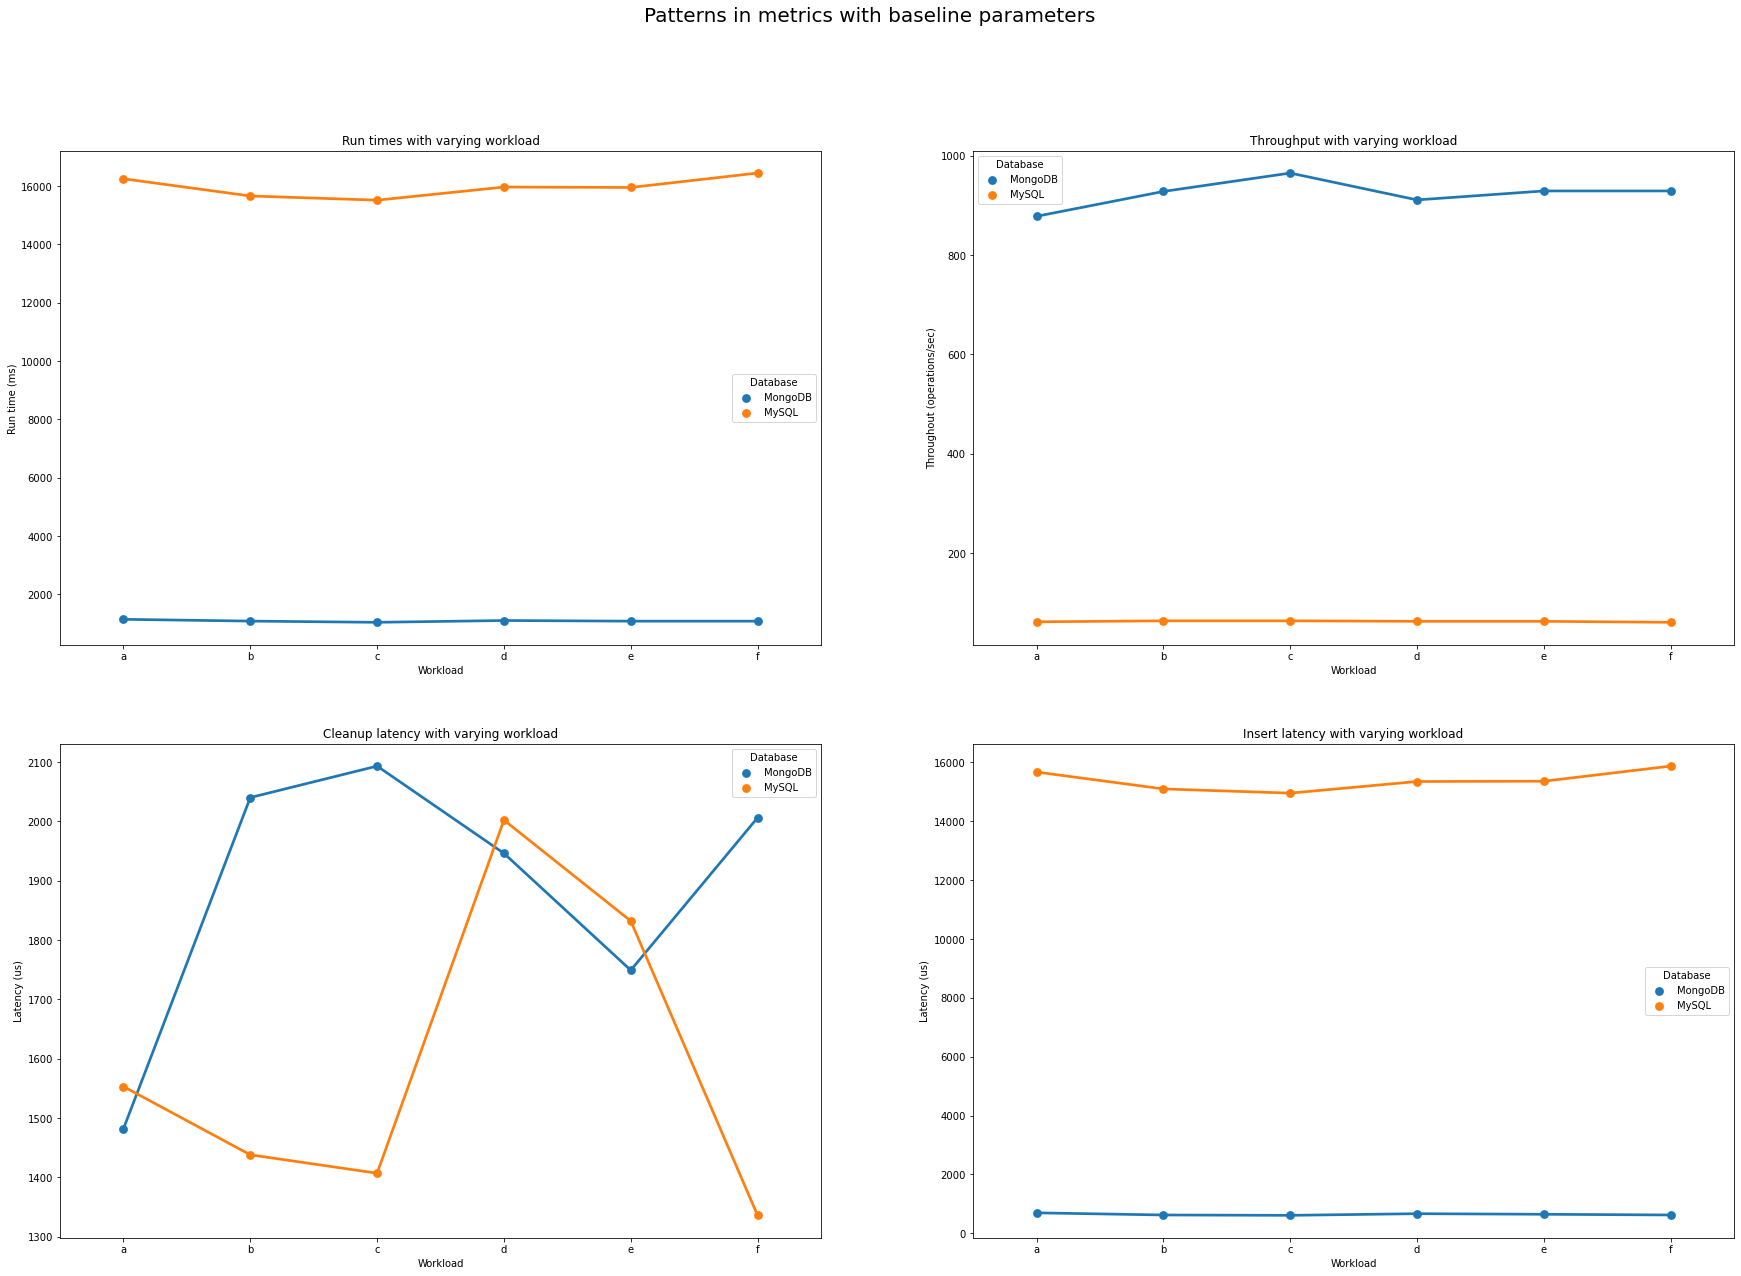

In [36]:
#Define layout
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(30, 20)

sns.pointplot(data=run_base, x="Workload", y="Run_Time_ms", hue="Database", ax=axes[0, 0])
sns.pointplot(data=run_base, x="Workload", y="Throughput_ops/sec", hue="Database", ax=axes[0, 1])
sns.pointplot(data=run_base, x="Workload", y="Ave_Latency_Cleanup_us", hue="Database", ax=axes[1, 0])
sns.pointplot(data=run_base, x="Workload", y="Ave_Latency_Insert_us", hue="Database", ax=axes[1, 1])

fig.suptitle("Patterns in metrics with baseline parameters", fontsize=20)

axes[0, 0].set_xlabel("Workload")
axes[0, 0].set_ylabel("Run time (ms)")
axes[0, 0].set_title("Run times with varying workload")

axes[0, 1].set_xlabel("Workload")
axes[0, 1].set_ylabel("Throughout (operations/sec)")
axes[0, 1].set_title("Throughput with varying workload")

axes[1, 0].set_xlabel("Workload")
axes[1, 0].set_ylabel("Latency (us)")
axes[1, 0].set_title("Cleanup latency with varying workload")

axes[1, 1].set_xlabel("Workload")
axes[1, 1].set_ylabel("Latency (us)")
axes[1, 1].set_title("Insert latency with varying workload")

#Run time and throughput are tracking basically the same thing- one normalises for operations (both are measuring efficiency)
#I will include both going forwards but it is not strictly necessary

Both run time and throughput show MongoDB is more efficient than MYSQL. Cleanup latency performance varies with workload, with neither database being universally better. Insert latency shows greater performance for MongoDB. 

In [4]:
#Look into the effects of varying other parameters on metrics
#I will compare the effects of varying threads, record and operation counts now for each

#Extract data for MongoDB
run_mongo_threads = df[(df["Record_counts"] == 1000) & (df["Operation_counts"] == 1000) & (df["Database"] == "MongoDB")]
run_mongo_records = df[(df["Threads"] == 1) & (df["Operation_counts"] == 1000) & (df["Database"] == "MongoDB")]
run_mongo_operations = df[(df["Threads"] == 1) & (df["Record_counts"] == 1000) & (df["Database"] == "MongoDB")]

#Extract data for MySQL
run_mysql_threads = df[(df["Record_counts"] == 1000) & (df["Operation_counts"] == 1000) & (df["Database"] == "MySQL")]
run_mysql_records = df[(df["Threads"] == 1) & (df["Operation_counts"] == 1000) & (df["Database"] == "MySQL")]
run_mysql_operations = df[(df["Threads"] == 1) & (df["Record_counts"] == 1000) & (df["Database"] == "MySQL")]

# Effects of varying thread count

The effects of varying thread count was evaluated to determine the robustness against increasing demand for each databse (scalability). In the context of big data analysis, high scalability is a highly desirable characteristic for a database. A highly scalable database will see throughput increase linearly with increasing threads (it is able to handle a high level of concurrency). Where a plateau is observed, the database is less scalable. 

Additionally, the limits of the dataset may be evaluated based on the relationship between thread count and performance metrics like throughput. Where a significant increase in latency is observed this is an indication that the database can no longer handle the demand placed on it. 

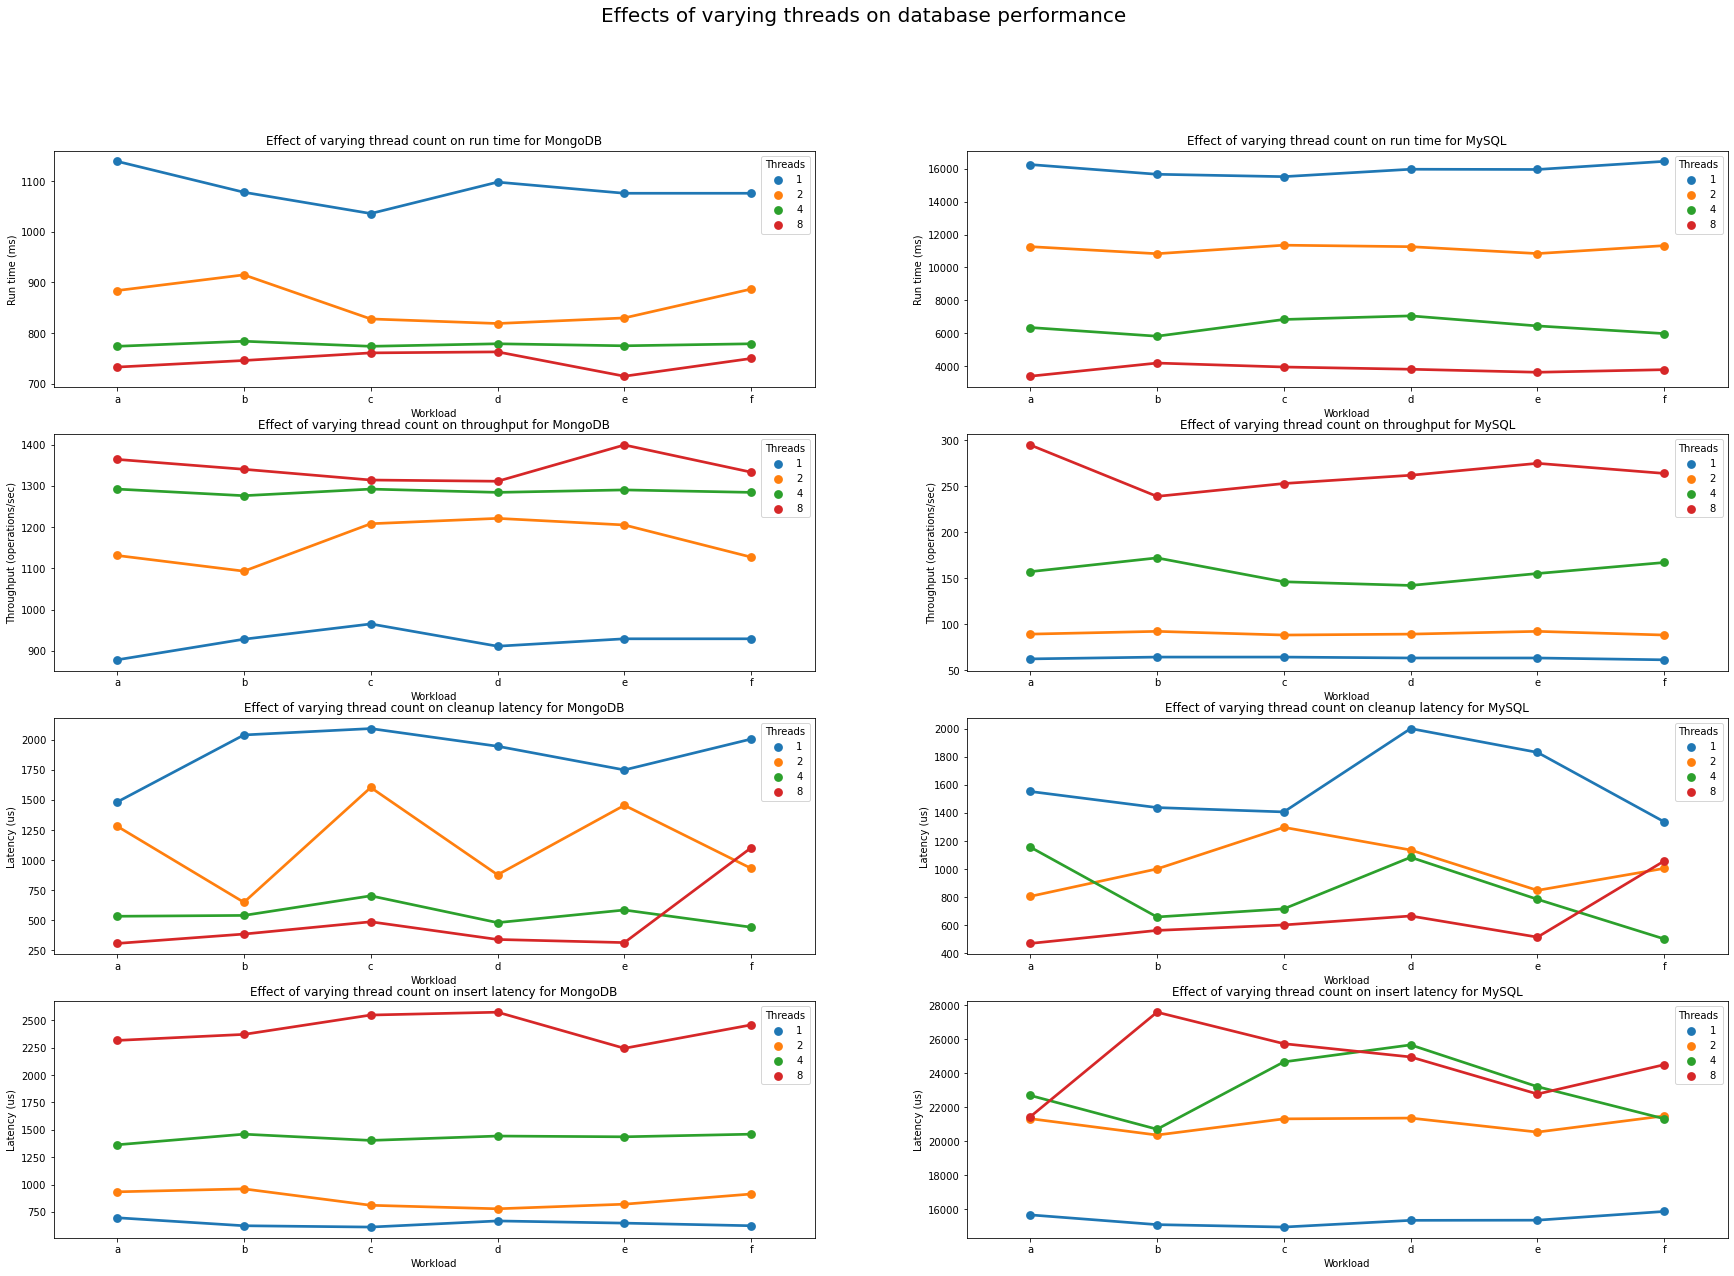

In [6]:
#Define layout
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(30, 20)

#Create plots
#MongoDB side
sns.pointplot(data=run_mongo_threads, x="Workload", y="Run_Time_ms", hue="Threads", ax=axes[0, 0])
sns.pointplot(data=run_mongo_threads, x="Workload", y="Throughput_ops/sec", hue="Threads", ax=axes[1, 0])
sns.pointplot(data=run_mongo_threads, x="Workload", y="Ave_Latency_Cleanup_us", hue="Threads", ax=axes[2, 0])
sns.pointplot(data=run_mongo_threads, x="Workload", y="Ave_Latency_Insert_us", hue="Threads", ax=axes[3, 0])

#MySQL side
sns.pointplot(data=run_mysql_threads, x="Workload", y="Run_Time_ms", hue="Threads", ax=axes[0, 1])
sns.pointplot(data=run_mysql_threads, x="Workload", y="Throughput_ops/sec", hue="Threads", ax=axes[1, 1])
sns.pointplot(data=run_mysql_threads, x="Workload", y="Ave_Latency_Cleanup_us", hue="Threads", ax=axes[2, 1])
sns.pointplot(data=run_mysql_threads, x="Workload", y="Ave_Latency_Insert_us", hue="Threads", ax=axes[3, 1])

#Set title and labels
fig.suptitle("Effects of varying thread count on database performance", fontsize=20)

axes[0, 0].set_xlabel("Workload")
axes[0, 0].set_ylabel("Run time (ms)")
axes[0, 0].set_title("Effect of varying thread count on run time for MongoDB")

axes[1, 0].set_xlabel("Workload")
axes[1, 0].set_ylabel("Throughput (operations/sec)")
axes[1, 0].set_title("Effect of varying thread count on throughput for MongoDB")

axes[2, 0].set_xlabel("Workload")
axes[2, 0].set_ylabel("Latency (us)")
axes[2, 0].set_title("Effect of varying thread count on cleanup latency for MongoDB")

axes[3, 0].set_xlabel("Workload")
axes[3, 0].set_ylabel("Latency (us)")
axes[3, 0].set_title("Effect of varying thread count on insert latency for MongoDB")

axes[0, 1].set_xlabel("Workload")
axes[0, 1].set_ylabel("Run time (ms)")
axes[0, 1].set_title("Effect of varying thread count on run time for MySQL")

axes[1, 1].set_xlabel("Workload")
axes[1, 1].set_ylabel("Throughput (operations/sec)")
axes[1, 1].set_title("Effect of varying thread count on throughput for MySQL")

axes[2, 1].set_xlabel("Workload")
axes[2, 1].set_ylabel("Latency (us)")
axes[2, 1].set_title("Effect of varying thread count on cleanup latency for MySQL")

axes[3, 1].set_xlabel("Workload")
axes[3, 1].set_ylabel("Latency (us)")
axes[3, 1].set_title("Effect of varying thread count on insert latency for MySQL")

#Display plot
plt.show()

In both cases, increasing threads decreases run time- this is an intuitive observation. This is the case for all workloads, however it is not observed to the same degree in all cases- again an intuitive observation. Latency refers to the time it takes for a system to respond to a request or operation. For workload f, it is seen that cleanup latency with threads=8 is greater than threads=2 and 4. This implies that the two databases have reached their limits for the characteristics of workload f before this point- as insert latency does not have the same issue we can see that the cleanup may be considered a performance bottleneck in this case.

# Effects of varying records count

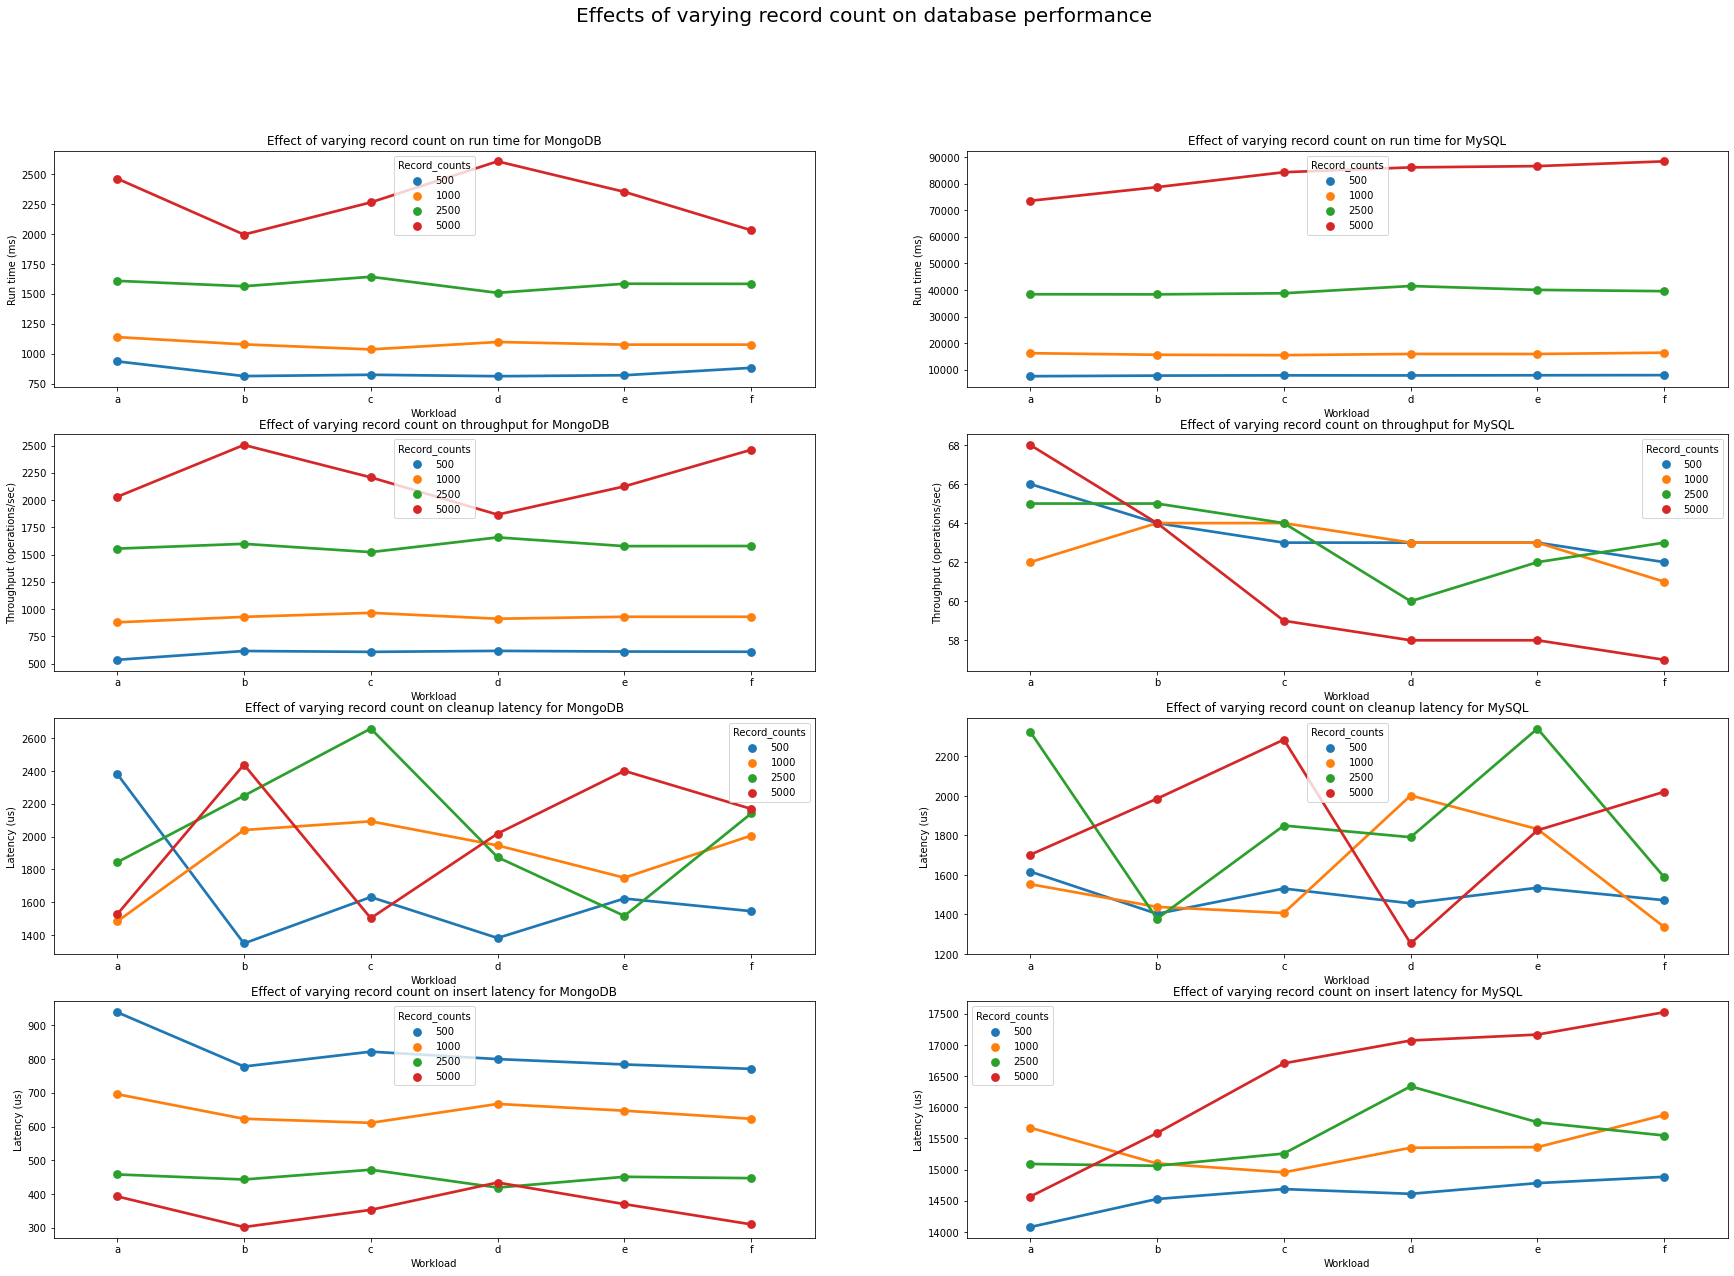

In [7]:
#Define layout
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(30, 20)

#Create plots
#MongoDB side
sns.pointplot(data=run_mongo_records, x="Workload", y="Run_Time_ms", hue="Record_counts", ax=axes[0, 0])
sns.pointplot(data=run_mongo_records, x="Workload", y="Throughput_ops/sec", hue="Record_counts", ax=axes[1, 0])
sns.pointplot(data=run_mongo_records, x="Workload", y="Ave_Latency_Cleanup_us", hue="Record_counts", ax=axes[2, 0])
sns.pointplot(data=run_mongo_records, x="Workload", y="Ave_Latency_Insert_us", hue="Record_counts", ax=axes[3, 0])

#MySQL side
sns.pointplot(data=run_mysql_records, x="Workload", y="Run_Time_ms", hue="Record_counts", ax=axes[0, 1])
sns.pointplot(data=run_mysql_records, x="Workload", y="Throughput_ops/sec", hue="Record_counts", ax=axes[1, 1])
sns.pointplot(data=run_mysql_records, x="Workload", y="Ave_Latency_Cleanup_us", hue="Record_counts", ax=axes[2, 1])
sns.pointplot(data=run_mysql_records, x="Workload", y="Ave_Latency_Insert_us", hue="Record_counts", ax=axes[3, 1])

#Set title and labels
fig.suptitle("Effects of varying record count on database performance", fontsize=20)

axes[0, 0].set_xlabel("Workload")
axes[0, 0].set_ylabel("Run time (ms)")
axes[0, 0].set_title("Effect of varying record count on run time for MongoDB")

axes[1, 0].set_xlabel("Workload")
axes[1, 0].set_ylabel("Throughput (operations/sec)")
axes[1, 0].set_title("Effect of varying record count on throughput for MongoDB")

axes[2, 0].set_xlabel("Workload")
axes[2, 0].set_ylabel("Latency (us)")
axes[2, 0].set_title("Effect of varying record count on cleanup latency for MongoDB")

axes[3, 0].set_xlabel("Workload")
axes[3, 0].set_ylabel("Latency (us)")
axes[3, 0].set_title("Effect of varying record count on insert latency for MongoDB")

axes[0, 1].set_xlabel("Workload")
axes[0, 1].set_ylabel("Run time (ms)")
axes[0, 1].set_title("Effect of varying record count on run time for MySQL")

axes[1, 1].set_xlabel("Workload")
axes[1, 1].set_ylabel("Throughput (operations/sec)")
axes[1, 1].set_title("Effect of varying record count on throughput for MySQL")

axes[2, 1].set_xlabel("Workload")
axes[2, 1].set_ylabel("Latency (us)")
axes[2, 1].set_title("Effect of varying record count on cleanup latency for MySQL")

axes[3, 1].set_xlabel("Workload")
axes[3, 1].set_ylabel("Latency (us)")
axes[3, 1].set_title("Effect of varying record count on insert latency for MySQL")

#Display plot
plt.show()

The relationship between record count and run time is as expected- as records increase the run time increases. The throughput metric is interesting in this comparison. For MongoDB, as record count increases the database becomes less efficient regardless of workload- which is expected. However for MySQL this is not necessarily the case and for some workloads the throughput is higher where greater record count is used (see workload a). Regardless, the performance of MongoDB is prefereable with regards to the throughput parameter at all record counts evaluated. Latency varies in both MySQL and MongoDB with no clear trend with regards to record count or workload present in these visualisations- the cleanup latency seems to be comparable for the two which is the only assessed parameter where this is the case. MongoDB has a significantly greater performance with regards to insert latency. Broadly speaking, it is likely that cleanup latency is a much more significant bottleneck than in MySQL where the performance is overall slower.

# Effects of varying operations count

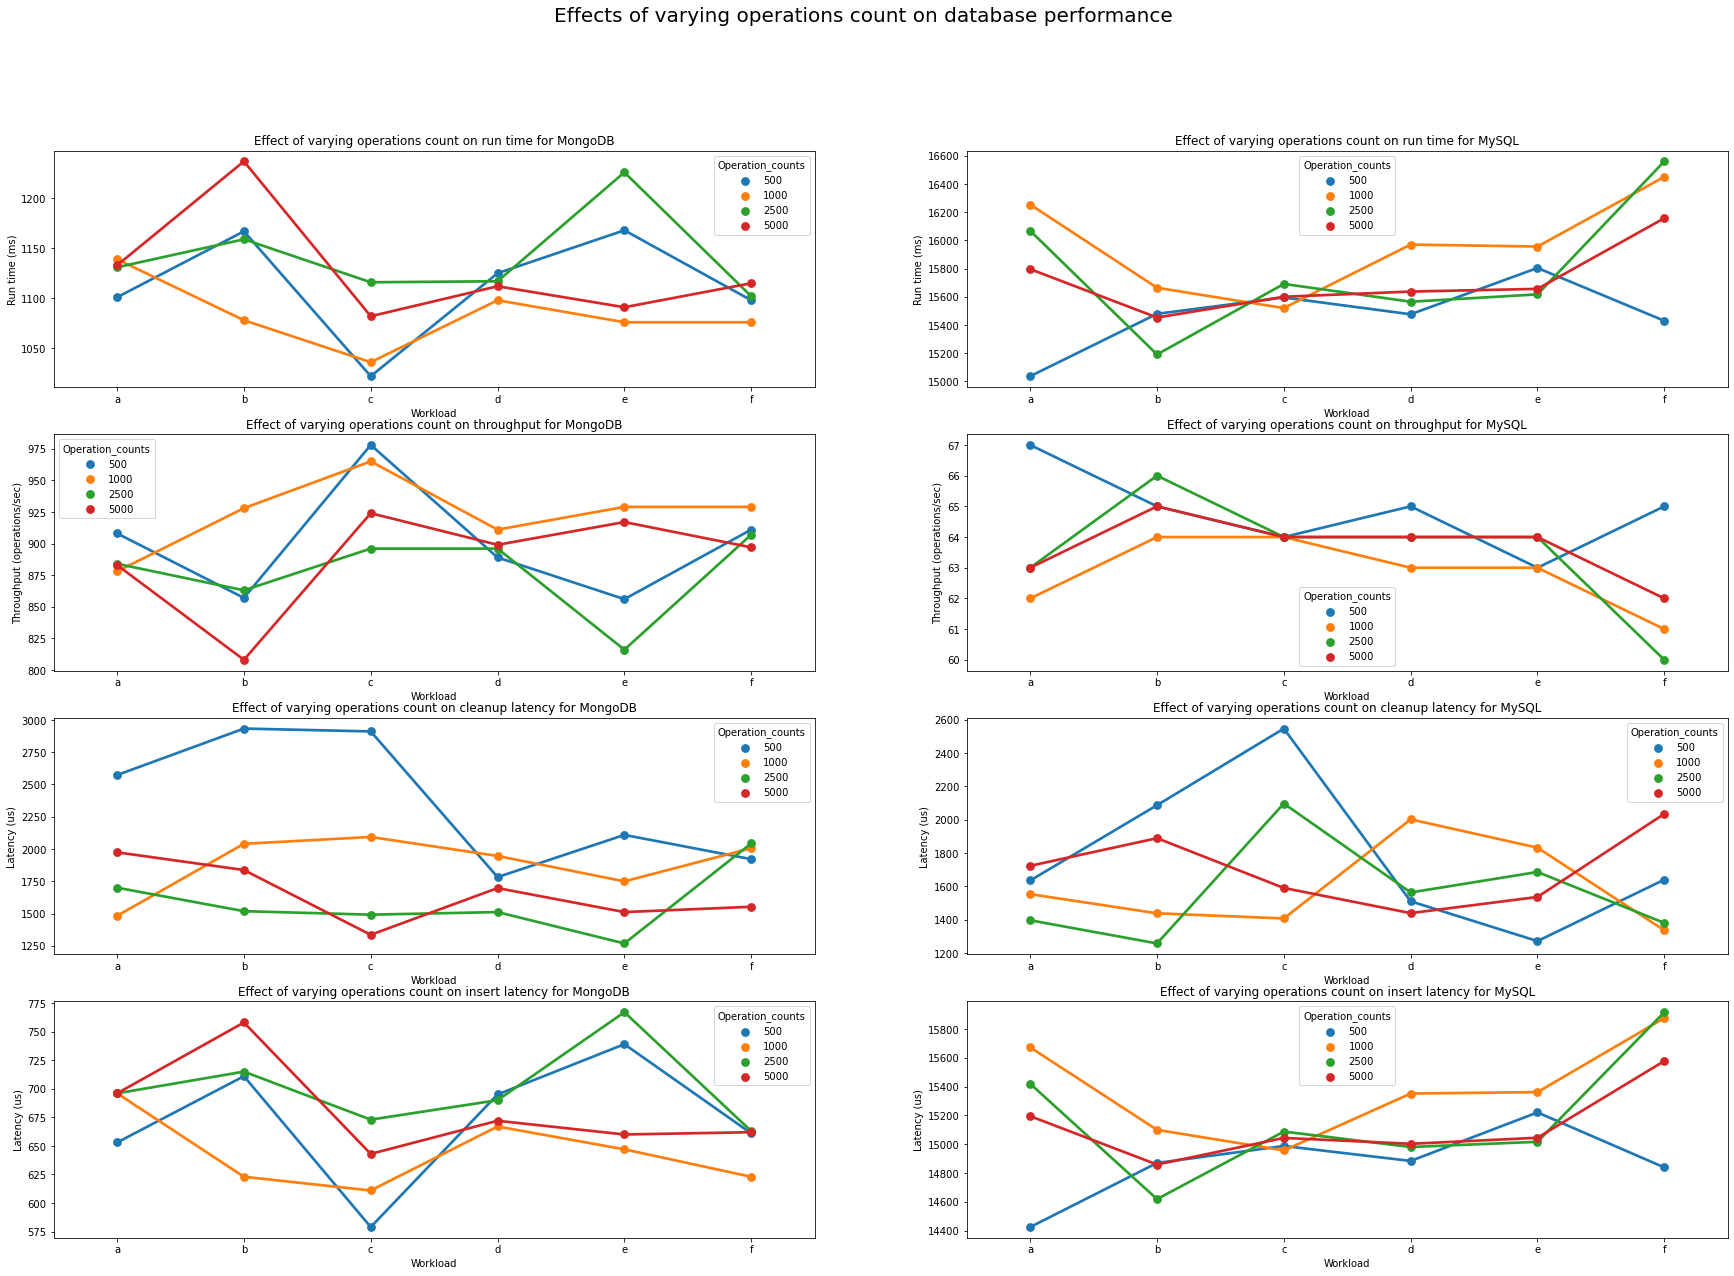

In [8]:
#Define layout
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(30, 20)

#Create plots
#MongoDB side
sns.pointplot(data=run_mongo_operations, x="Workload", y="Run_Time_ms", hue="Operation_counts", ax=axes[0, 0])
sns.pointplot(data=run_mongo_operations, x="Workload", y="Throughput_ops/sec", hue="Operation_counts", ax=axes[1, 0])
sns.pointplot(data=run_mongo_operations, x="Workload", y="Ave_Latency_Cleanup_us", hue="Operation_counts", ax=axes[2, 0])
sns.pointplot(data=run_mongo_operations, x="Workload", y="Ave_Latency_Insert_us", hue="Operation_counts", ax=axes[3, 0])

#MySQL side
sns.pointplot(data=run_mysql_operations, x="Workload", y="Run_Time_ms", hue="Operation_counts", ax=axes[0, 1])
sns.pointplot(data=run_mysql_operations, x="Workload", y="Throughput_ops/sec", hue="Operation_counts", ax=axes[1, 1])
sns.pointplot(data=run_mysql_operations, x="Workload", y="Ave_Latency_Cleanup_us", hue="Operation_counts", ax=axes[2, 1])
sns.pointplot(data=run_mysql_operations, x="Workload", y="Ave_Latency_Insert_us", hue="Operation_counts", ax=axes[3, 1])

#Set title and labels
fig.suptitle("Effects of varying operations count on database performance", fontsize=20)

axes[0, 0].set_xlabel("Workload")
axes[0, 0].set_ylabel("Run time (ms)")
axes[0, 0].set_title("Effect of varying operations count on run time for MongoDB")

axes[1, 0].set_xlabel("Workload")
axes[1, 0].set_ylabel("Throughput (operations/sec)")
axes[1, 0].set_title("Effect of varying operations count on throughput for MongoDB")

axes[2, 0].set_xlabel("Workload")
axes[2, 0].set_ylabel("Latency (us)")
axes[2, 0].set_title("Effect of varying operations count on cleanup latency for MongoDB")

axes[3, 0].set_xlabel("Workload")
axes[3, 0].set_ylabel("Latency (us)")
axes[3, 0].set_title("Effect of varying operations count on insert latency for MongoDB")

axes[0, 1].set_xlabel("Workload")
axes[0, 1].set_ylabel("Run time (ms)")
axes[0, 1].set_title("Effect of varying operations count on run time for MySQL")

axes[1, 1].set_xlabel("Workload")
axes[1, 1].set_ylabel("Throughput (operations/sec)")
axes[1, 1].set_title("Effect of varying operations count on throughput for MySQL")

axes[2, 1].set_xlabel("Workload")
axes[2, 1].set_ylabel("Latency (us)")
axes[2, 1].set_title("Effect of varying operations count on cleanup latency for MySQL")

axes[3, 1].set_xlabel("Workload")
axes[3, 1].set_ylabel("Latency (us)")
axes[3, 1].set_title("Effect of varying operations count on insert latency for MySQL")

#Display plot
plt.show()

Operations count does not seem to have as significant impact on the performance parameters assessed in either case- there is no clear trends observed compared to the other parameters which are assessed. In these graphs the trends seem to be dictated to a greater extent by the workload used rather than the operations count.

# Test using parameters from the database used in the assessment

The following is a test which aims to simulate the data used in the assignment as closely as possible in both databases. 

In [9]:
#Using a read-heavy workload -workload b is suitable as it is 95% read
#Record count is 50,000 approximately equal to the number of rows in the dataset
#Operations count is not clear as my strategy is dynamic based on what is found during EDA
#It is only me using the dataset so the operations count will be low regardless- I will go with 20 for this comparison

#Importing data
df_dbtest = pd.read_csv("YCSB_DBtest.csv")

In [10]:
df_dbtest.head()

,Database,Run_Time_ms,Throughput_ops/sec,Ave_Latency_Cleanup_us,Min_Latency_Cleanup_us,Max_Latency_Cleanup_us,Ave_Latency_Insert_us,Min_Latency_Insert_us,Max_Latency_Insert_us
0,MongoDB,19091,2619,3135,3134,3135,350,72,112383
1,MySQL,1012612,49,4614,4612,4615,20206,9512,483583


Text(0.5, 1.0, 'Comparison of Insert Latency for MongoDB and MySQL')

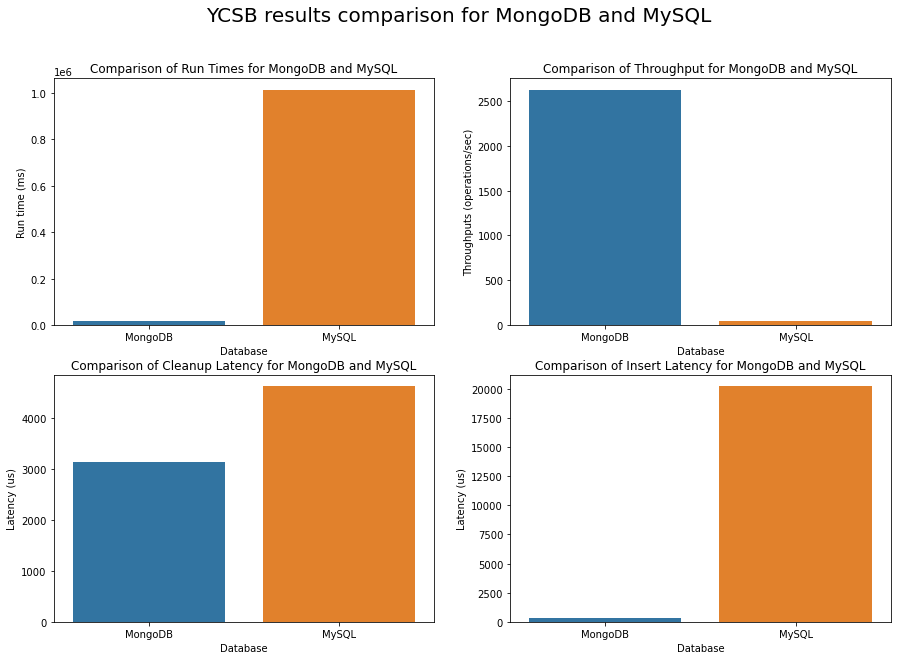

In [17]:
#Define layout
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 10)

#Create plots
#MongoDB side
sns.barplot(data=df_dbtest, x="Database", y="Run_Time_ms", ax=axes[0, 0])
sns.barplot(data=df_dbtest, x="Database", y="Throughput_ops/sec", ax=axes[0, 1])
sns.barplot(data=df_dbtest, x="Database", y="Ave_Latency_Cleanup_us", ax=axes[1, 0])
sns.barplot(data=df_dbtest, x="Database", y="Ave_Latency_Insert_us", ax=axes[1, 1])

#Define titles and axis labels
fig.suptitle("YCSB results comparison for MongoDB and MySQL", fontsize=20)

axes[0, 0].set_xlabel("Database")
axes[0, 0].set_ylabel("Run time (ms)")
axes[0, 0].set_title("Comparison of Run Times for MongoDB and MySQL")

axes[0, 1].set_xlabel("Database")
axes[0, 1].set_ylabel("Throughputs (operations/sec)")
axes[0, 1].set_title("Comparison of Throughput for MongoDB and MySQL")

axes[1, 0].set_xlabel("Database")
axes[1, 0].set_ylabel("Latency (us)")
axes[1, 0].set_title("Comparison of Cleanup Latency for MongoDB and MySQL")

axes[1, 1].set_xlabel("Database")
axes[1, 1].set_ylabel("Latency (us)")
axes[1, 1].set_title("Comparison of Insert Latency for MongoDB and MySQL")

Run time: MongoDB is significantly faster than MySQL- in the context of big data analytics this is an important consideration. Based on this parameter MongoDB would be a preferable database to use. 

Throughput: Consistent with the run time parameter, MongoDB can 